In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import csv


In [2]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla P100-SXM2-16GB (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)


In [3]:
np.random.seed(7388)


In [4]:
def data_power_consumption(path_to_dataset,
                           sequence_length=50,
                           ratio=1.0,
                          column_index=2):
    num_lines = sum(1 for line in open(path_to_dataset))

    max_values = int(ratio * num_lines)
    
    with open(path_to_dataset) as f:
        data = csv.reader(f, delimiter=";")
        power = []
        nb_of_values = 0
        for line in data:
            try:
                power.append(float(line[column_index]))
                nb_of_values += 1
            except ValueError:
                pass
            # 2049280.0 is the total number of valid values, i.e. ratio = 1.0
            if nb_of_values >= max_values:
                break

    print "Data loaded from csv. Formatting..."

    result = []
    for index in range(len(power) - sequence_length):
        result.append(power[index: index + sequence_length])
    result = np.array(result)  # shape (2049230, 50)

    result_mean = result.mean()
    result -= result_mean
    print "Mean : ", result_mean
    print "Data  : ", result.shape

    row = int(round(0.9 * result.shape[0]))
    train = result[:row, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = result[row:, :-1]
    y_test = result[row:, -1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return [X_train, y_train, X_test, y_test]



In [5]:
def build_model():
    model = Sequential()
    layers = [1, 50, 100, 1]

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print "Compilation Time : ", time.time() - start
    return model


Lets load the parameters required for each file. 
For Power Consumption Datset, the data is obtained from the UCI repository (https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption)
I used only 0.25% (1/400) of the dataset. We used the colum index as 2 to get the Global Active Power column from the csv file. 

For the sinWave dataset, the whole data set was used and since there is only one column, the column index is set to 0

Feel free to play around with the sequence length. 

In [6]:
global_start_time = time.time()
nEpochs = 50
ratio = 1.0/400.0
sequence_length = 50
column_index = 2
path_to_dataset = 'household_power_consumption.txt'
#path_to_dataset = 'sinwave.txt'

In [7]:
X_train, y_train, X_test, y_test = data_power_consumption(
            path_to_dataset, sequence_length, ratio, column_index)

Data loaded from csv. Formatting...
Mean :  1.66426010121
Data  :  (5138, 50)


In [8]:
model = build_model()

Compilation Time :  0.0044960975647


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [10]:
model.fit(X_train, y_train, 
          batch_size=512, 
          nb_epoch=nEpochs,
          validation_split=0.05, 
          callbacks=[early_stopping])

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl


Train on 4392 samples, validate on 232 samples
Epoch 1/50
4392/4392 [==============================] - 0s - loss: 0.7123 - val_loss: 0.4456
Epoch 2/50
4392/4392 [==============================] - 0s - loss: 0.4504 - val_loss: 0.3949

In [11]:
predicted = model.predict(X_test)
predicted = np.reshape(predicted, (predicted.size,))

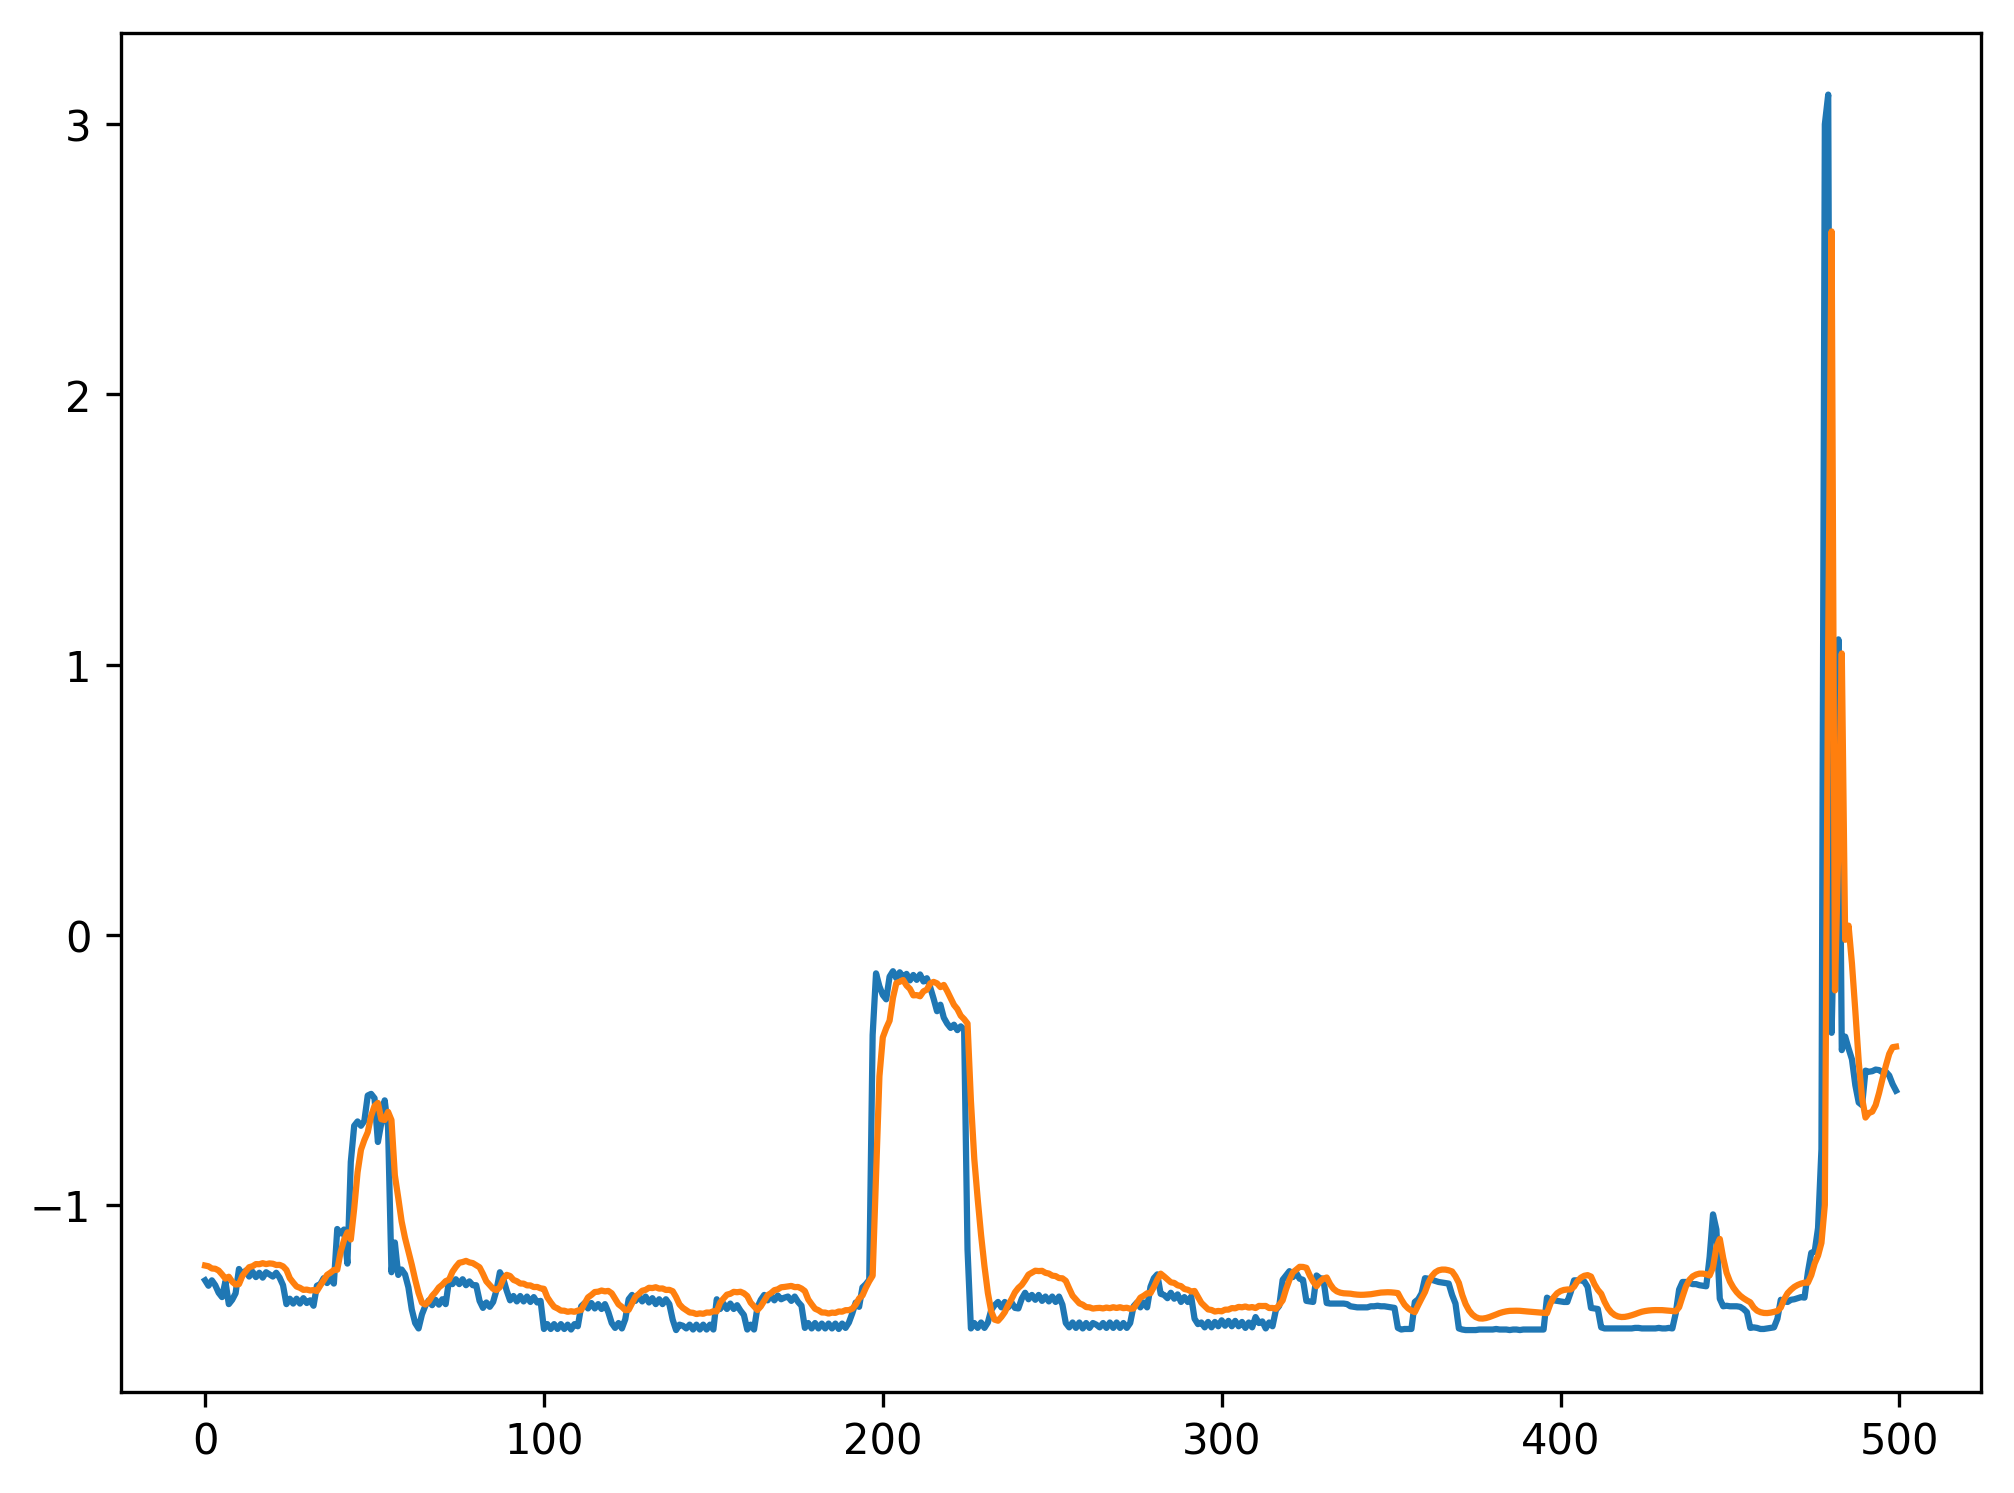

In [12]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.plot(y_test[:500])
plt.plot(predicted[:500])
plt.show()

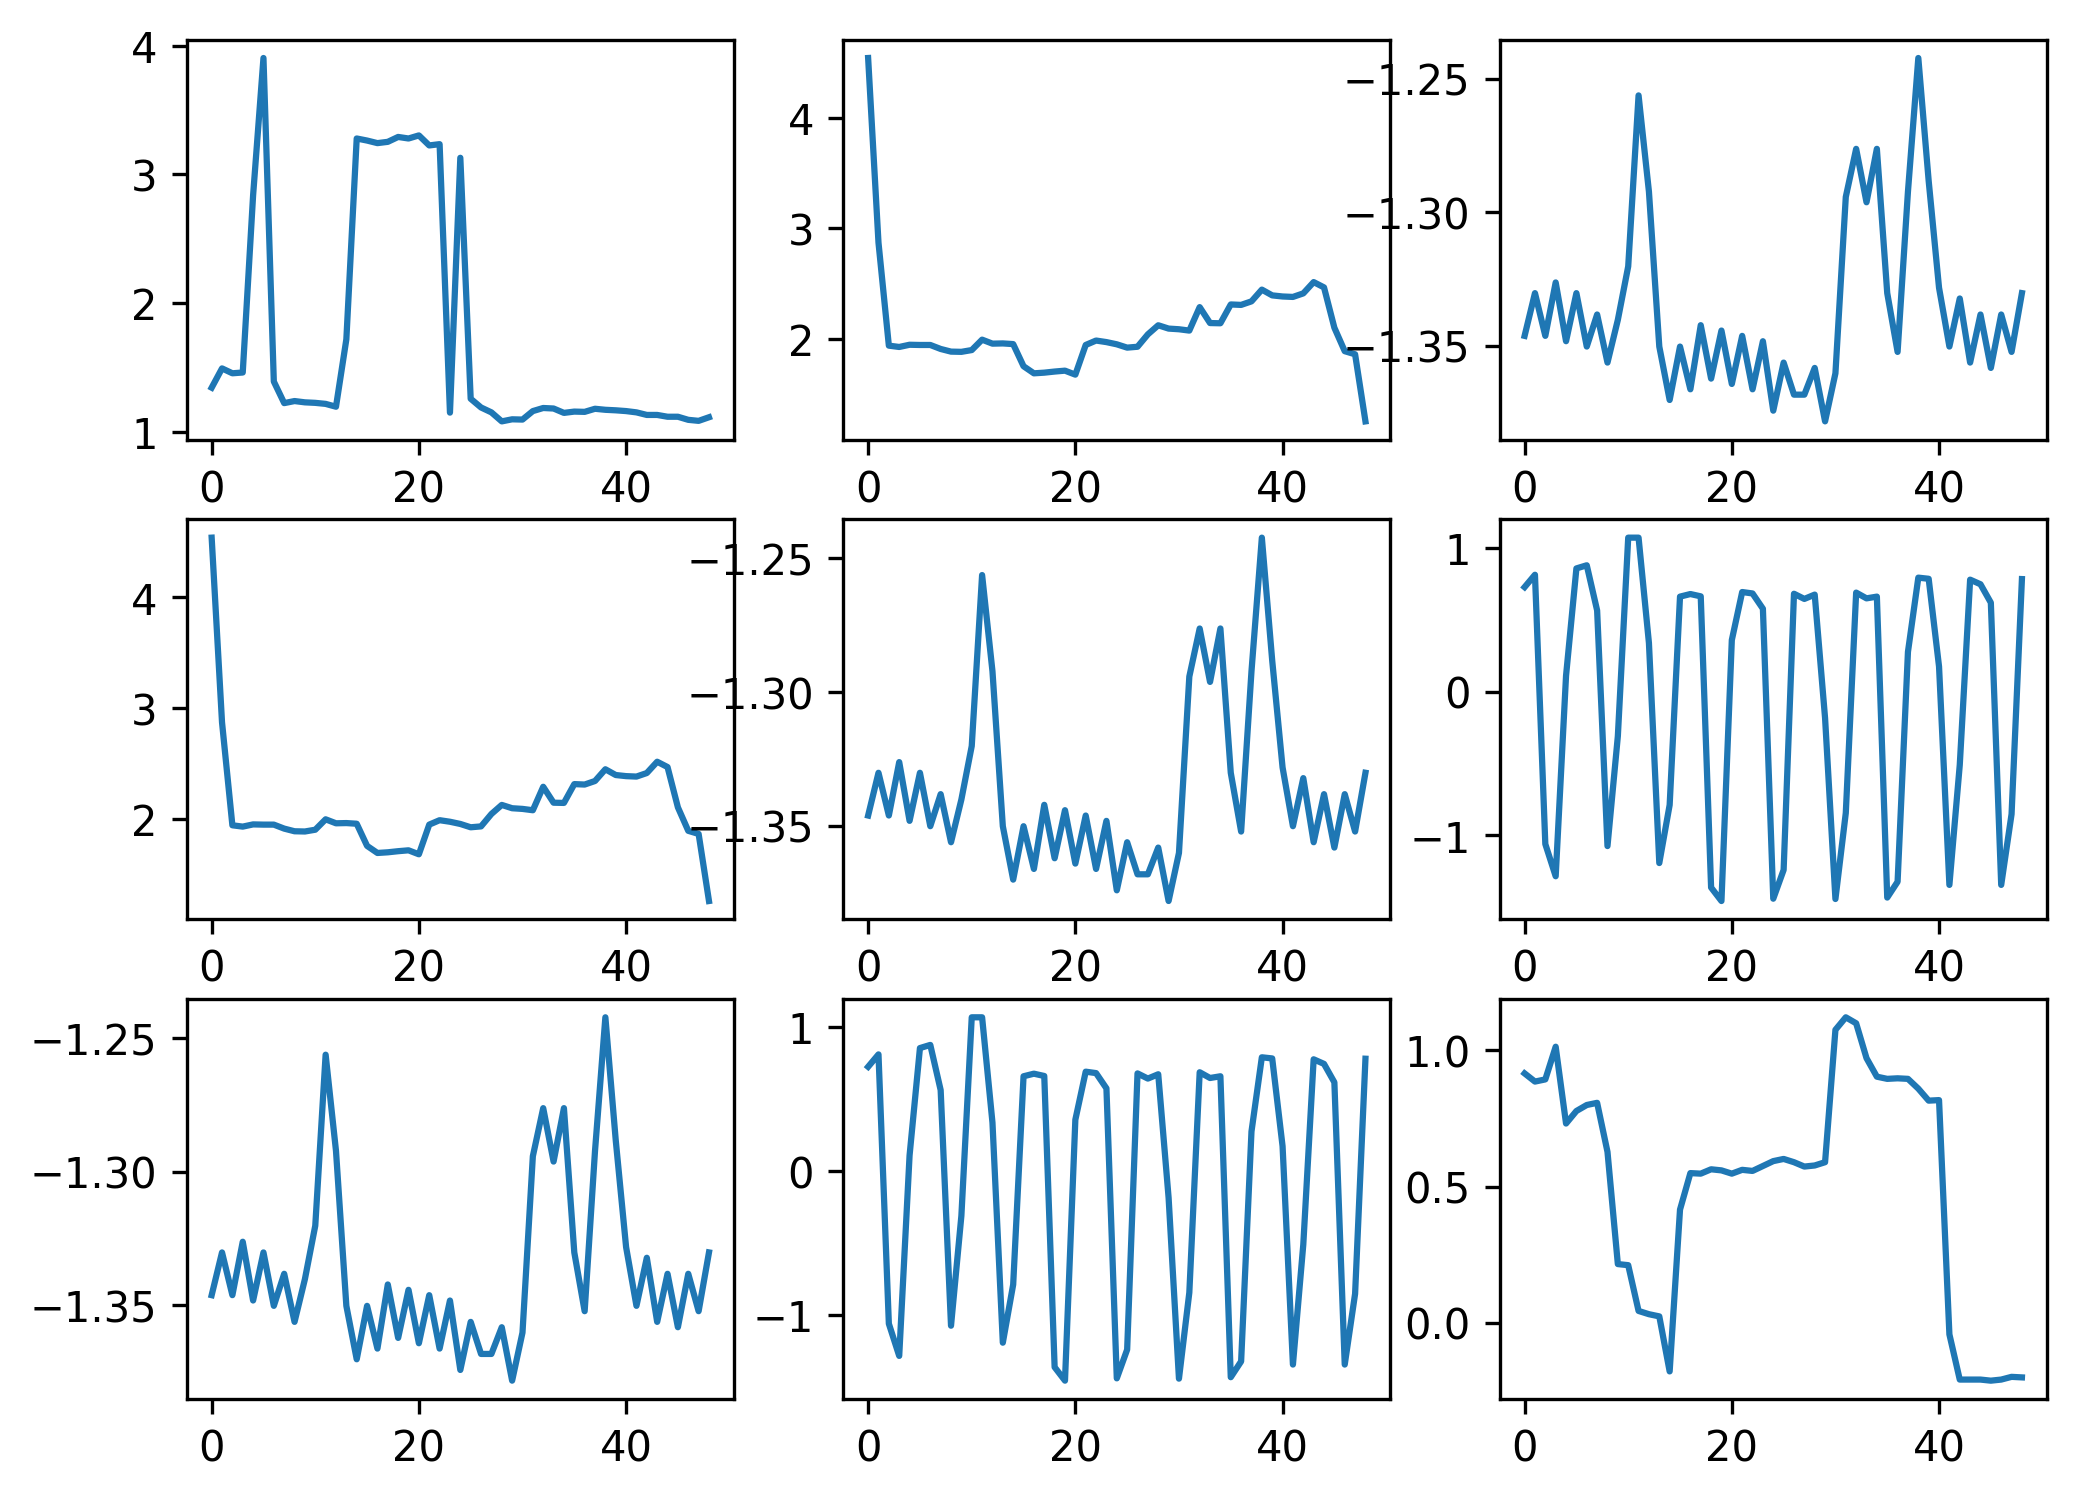

In [13]:
numValues = 3
f, axarr = plt.subplots(numValues, numValues, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
for i in range(0,numValues):
    for j in range(0,numValues):
        axarr[i, j].plot(X_train[:][i+j])
plt.show()

In [14]:
X_train.shape

(4624, 49, 1)